In [15]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
%autoreload 2
import h5py
from matplotlib import colors
import matplotlib.pyplot as plt
import multiprocessing
from neural_analysis.matIO import loadmat
import numpy as np
import os
import pandas as pd
import ssm
from ssm.util import find_permutation
import sys
import time
from tqdm.auto import tqdm

sys.path.append('../..')
from multi_process import slds_eigs_worker
from nld_utils import simulate_lorenz
from up_down import get_up_down
from utils import get_binary_stimuli, get_sample_interval, load, save

## Load Neural Data

In [19]:
# filename = '../../__data__/Mary-Anesthesia-20160809-01.mat'
filename = r'/home/adameisen/millerdata/common/datasets/anesthesia/mat/propofolPuffTone/Mary-Anesthesia-20160809-01.mat'
# filename = r'/home/adameisen/millerdata/common/datasets/anesthesia/mat/propofolWakeup/Mary-Anesthesia-20170203-02.mat'
print("Loading data ...")
start = time.process_time()
# electrode_info, lfp, lfp_schema, session_info, spike_times, unit_info = loadmat(filename, variables=['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'unitInfo'], verbose=False)
electrode_info, lfp_schema, session_info, unit_info = loadmat(filename, variables=['electrodeInfo', 'lfpSchema', 'sessionInfo', 'unitInfo'], verbose=False)
dt = lfp_schema['smpInterval'][0]

f = h5py.File(filename, 'r')
airPuff_binary, audio_binary = get_binary_stimuli(f)

print(f"Data loaded (took {time.process_time() - start:.2f} seconds)")

Loading data ...
Data loaded (took 2.25 seconds)


In [20]:
# mat_dir = r'/home/adameisen/millerdata/common/datasets/anesthesia/mat/propofolPuffTone'
# for file in os.listdir(mat_dir):
#     filename = os.path.join(mat_dir, file)
#     electrode_info, lfp_schema, session_info, unit_info = loadmat(filename, variables=['electrodeInfo', 'lfpSchema', 'sessionInfo', 'unitInfo'], verbose=False)
#     print(session_info['drug'])

In [14]:
loadmat(r'/home/adameisen/millerdata/common/datasets/anesthesia/mat/anesthesia_databases.mat')

fileInfo : dict with keys[session,file,dataSource,recordSys,recordSysModel,version,dateTime,duration,clockFreq,waveSmpFreq,numWaveSmps,numWavePreSmps,waveBitRes,analogBitRes,Properties,]

sessionInfo : dict with keys[session,subject,tasks,areas,arrays,NSPs,hasDrug,drug,drugDose,drugDuration,drugStart,drugEnd,eyesClose,eyesOpen,drugTask,hasWakeUpTest,numTrials,numCorrect,pctCorrect,pctBadTrials,Properties,]

spikeChnlInfo : dict with keys[chnlID,electrode,channel,chnlLabel,numUnits,numUnitSpikes,numUnsortedSpikes,smpRate,digitalRange,d2aFactor,analogRange,analogUnits,filterCutoff,session,file,Properties,]

analogChnlInfo : dict with keys[chnlID,electrode,channel,chnlLabel,numSamples,smpRate,digitalRange,d2aFactor,analogRange,analogUnits,filterCutoff,isLFP,isAIN,session,file,Properties,]

electrodeInfo : dict with keys[electrode,chnlID,channel,session,file,hasLFP,numUnits,hemisphere,area,array,NSP,gridLoc,Properties,]

unitInfo : dict with keys[unitID,electrode,channel,unit,numSpikes,chn

({'session': array(['MrJones-Anesthesia-20160105-01', 'MrJones-Anesthesia-20160107-01',
         'MrJones-Anesthesia-20160109-01', 'MrJones-Anesthesia-20160113-01',
         'MrJones-Anesthesia-20160121-01', 'MrJones-Anesthesia-20160123-01',
         'MrJones-Anesthesia-20160125-01', 'MrJones-Anesthesia-20160201-01',
         'MrJones-Anesthesia-20160206-01', 'MrJones-Anesthesia-20160210-01',
         'MrJones-Anesthesia-20160301-01', 'Mary-Anesthesia-20160809-01',
         'Mary-Anesthesia-20160818-02', 'Mary-Anesthesia-20160822-02',
         'Mary-Anesthesia-20160826-02', 'Mary-Anesthesia-20160831-02',
         'Mary-Anesthesia-20160902-02', 'Mary-Anesthesia-20160908-02',
         'Mary-Anesthesia-20160912-02', 'Mary-Anesthesia-20160914-02',
         'Mary-Anesthesia-20160916-02', 'MrJones-Anesthesia-20160412-01',
         'MrJones-Anesthesia-20160414-01', 'MrJones-Anesthesia-20160421-01',
         'MrJones-Anesthesia-20160423-02', 'MrJones-Anesthesia-20160425-01',
         'MrJones-

# Run

In [38]:
# --------
# User-guided SLDS parameters
# --------
latent_dim = 2 # number of latent dimensions
# transitions = "standard" # transition class
transitions = "standard"
stride = 10*60 # s
duration = 10*60 # s

length = int(duration/dt)
# start_times = np.arange(0, lfp.shape[0]*dt - duration + 0.1, stride).astype(int)
start_times = np.arange(0, lfp.shape[0]*dt - duration - 0.1, stride).astype(int)
start_times = np.hstack([start_times, lfp.shape[0]*dt - duration - 5])

# areas = ['vlPFC', 'FEF', 'CPB', '7b']
# areas = np.unique(electrode_info['area'])
areas = ['vlPFC']
unit_indices = np.arange(lfp.shape[1])[pd.Series(electrode_info['area']).isin(areas)]
var_names = [f"unit_{unit_num} {electrode_info['area'][unit_num]}" for unit_num in unit_indices]

# --------
# Set the parameters of the SLDS
# --------
emissions_dim = len(unit_indices)     # number of observed dimensions

data_dir = "../../__data__/slds/"
t = time.localtime()
timestamp = time.strftime('%b-%d-%Y_%H%M', t)
data_dir = os.path.join(data_dir, f"slds_big_run_latent_{latent_dim}_duration_{duration}_stride_{stride}_{timestamp}")
os.makedirs(data_dir, exist_ok=True)

In [39]:
anesthesia_bounds = [session_info['drugStart'][0], session_info['drugEnd'][1]]
param_list = []
for start_time in start_times:

    # --------
    # Set Disc States for Each Segment
    # --------
    piece_bounds = [start_time, start_time + duration]
    if piece_bounds[1] <= anesthesia_bounds[0] or piece_bounds[0] >= anesthesia_bounds[1]:
        # WAKEFUL
        n_disc_states = 2
    elif piece_bounds[1] > anesthesia_bounds[0] and piece_bounds[1] <= anesthesia_bounds[1]:
        if piece_bounds[0] < anesthesia_bounds[0]:
            # TRANSITION TO ANESTHESIA
            n_disc_states = 2
        else: # piece_bounds[0] >= anesthesia_bounds
            # FULL ANESTHESIA
            n_disc_states = 2
    else: # piece_bounds[0] > anesthesia_bounds[1] and piece_bounds[1] > anesthesia_bounds[1]
        # TRANSITION OUT OF ANESTHESIA
        n_disc_states = 2

    start_step = int(start_time/dt)
    data = lfp[start_step:start_step + length, unit_indices]
    param_list.append((start_time, start_step, data, transitions, emissions_dim, n_disc_states, latent_dim, data_dir))

In [ ]:
for param_tuple in tqdm(param_list):
    slds_eigs_worker(param_tuple, savefile=True, verbose=2)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

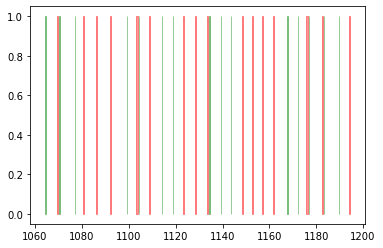

In [76]:
t = np.arange(results['start_time'], results['start_time'] + duration, dt)
# plt.fill_between(t, 0, 1, where=results['disc_states'])
plt.fill_between(t, 0, 1, where=airPuff_binary[results['start_step']:results['start_step'] + length], color='green', alpha=0.4)
plt.fill_between(t, 0, 1, where=audio_binary[results['start_step']:results['start_step'] + length], color='red', alpha=0.4)
plt.show()

# Analyze

In [21]:
%%time
data_dir = "/home/adameisen/Documents/MIT/code/ChaoticConsciousness/__data__/slds/slds_big_run_latent_2_duration_5_stride_5_Oct-28-2021_1833"
vis

CPU times: user 893 ms, sys: 3.99 s, total: 4.89 s
Wall time: 25.9 s


In [22]:
duration = 5
stride = 5
n_disc_states = 2
latent_dim = 2
stride = duration

In [7]:
# fig, axs = plt.subplots(2, 1, figsize=(14, 8))

# ax = axs[0]
# start_times = results.start_time
# mean_eigs = np.array([mat.mean() for mat in results.criticality_inds])
# ax.plot(start_times, mean_eigs)
# ax.set_xlabel('Time (s)', fontsize=14)
# ax.set_ylabel('Mean Criticality Index', fontsize=14)
# ax.set_title("Mean Across Discrete States", fontsize=14)
# ax.fill_between(np.arange(session_info['drugStart'][0], session_info['drugEnd'][0], dt), 
#                             mean_eigs.min(), mean_eigs.max(), color='plum', alpha=0.2, label='drug infusion 1')
# ax.fill_between(np.arange(session_info['drugStart'][1], session_info['drugEnd'][1], dt), 
#                             mean_eigs.min(), mean_eigs.max(), color='darkorchid', alpha=0.2, label='drug infusion 2')
# # ax.legend()

# ax = axs[1]
# mean_eigs = np.array([mat.mean(axis=1) for mat in results.criticality_inds])
# for i in range(n_disc_states):
#     ax.plot(start_times, mean_eigs[:, i], label=f'discrete state {i}')
# ax.set_xlabel('Time (s)', fontsize=14)
# # ax.set_ylabel('Mean Eigenvalue')
# ax.set_title("Mean for Each Discrete State", fontsize=14)
# ax.fill_between(np.arange(session_info['drugStart'][0], session_info['drugEnd'][0], dt), 
#                             mean_eigs.min(), mean_eigs.max(), color='C6', alpha=0.2, label='drug infusion 1')
# ax.fill_between(np.arange(session_info['drugStart'][1], session_info['drugEnd'][1], dt), 
#                             mean_eigs.min(), mean_eigs.max(), color='C7', alpha=0.2, label='drug infusion 2')

# plt.axvline(session_info['eyesClose'][-1]/60 if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']/60, linestyle='--', c='red', label="loss of consciousness")
# plt.axvline(session_info['eyesOpen'][-1]/60 if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']/60, linestyle='--', c='green', label="return of consciousness")

# ax.legend()
# ax.yaxis.set_tick_params(labelbottom=True)
# ax.set_ylabel('Mean Criticality Index', fontsize=14)

# # # make coloured portions the same size
# # ax = axs[0]
# # ax.fill_between(np.arange(session_info['drugStart'][0], session_info['drugEnd'][0], dt), 
# #                             mean_eigs.min(), mean_eigs.max(), color='plum', alpha=0.2, label='drug infusion 1')
# # ax.fill_between(np.arange(session_info['drugStart'][1], session_info['drugEnd'][1], dt), 
# #                             mean_eigs.min(), mean_eigs.max(), color='darkorchid', alpha=0.2, label='drug infusion 2')
# # ax.legend()

# plt.suptitle(f"Mean Criticality Index of SLDS Transition Matrix\nLatent Dim = {latent_dim}, Window = {duration} s", fontsize=18)
# plt.tight_layout()
# plt.show()

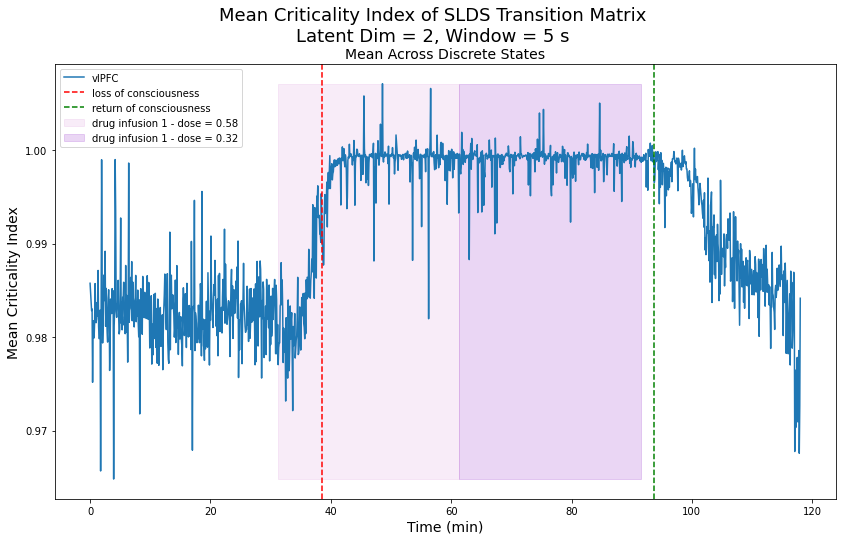

In [38]:
fig = plt.figure(figsize=(14, 8))

ax = plt.gca()
start_times = results.start_time/60
# mean_eigs = np.array([mat.mean() for mat in results.criticality_inds])
mean_eigs = np.zeros(len(results))
for i in range(len(results)):
    disc_states, counts = np.unique(results.disc_states.iloc[i], return_counts=True)
    mean_crit = 0
    for disc_state, count in zip(disc_states, counts):
        mean_crit += (count/np.sum(counts))*results.criticality_inds.iloc[i][disc_state].mean()
    mean_eigs[i] = mean_crit
ax.plot(start_times, mean_eigs, label='vlPFC')
ax.set_xlabel('Time (min)', fontsize=14)
ax.set_ylabel('Mean Criticality Index', fontsize=14)
ax.set_title("Mean Across Discrete States", fontsize=14)
min_val = mean_eigs.min()
max_val = mean_eigs.max()
ax.fill_between(np.arange(session_info['drugStart'][0], session_info['drugEnd'][0], stride)/60, 
                        min_val, max_val, color='plum', alpha=0.2, label=f"drug infusion 1 - dose = {session_info['drugDose'][0]}")
ax.fill_between(np.arange(session_info['drugStart'][1], session_info['drugEnd'][1], stride)/60, 
                        min_val, max_val, color='darkorchid', alpha=0.2, label=f"drug infusion 1 - dose = {session_info['drugDose'][1]}")

plt.axvline(session_info['eyesClose'][-1]/60 if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']/60, linestyle='--', c='red', label="loss of consciousness")
plt.axvline(session_info['eyesOpen'][-1]/60 if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']/60, linestyle='--', c='green', label="return of consciousness")
ax.legend()
plt.suptitle(f"Mean Criticality Index of SLDS Transition Matrix\nLatent Dim = {latent_dim}, Window = {duration} s", fontsize=18)
plt.show()

In [95]:
len(results)

1417

In [1]:
unit_indices = run_params['unit_indices']
length = run_params['length']
n_samp = 10
T_samp = 1000

interval = 5 # number of windows to use
indices = np.arange(len(results) - 1)
indices = [i for i in indices if i % 5 == 0]

start_times = np.zeros(len(indices))

prediction_mse = np.zeros((len(indices), len(ts), T_samp))
for num, index in enumerate(tqdm(indices)):
    row = results.iloc[index]
    start_times[num] = row.start_time
    
    slds = row.slds
    start_step = row.start_step
    ts = [results.iloc[index + 1].start_step]
#     ts = [results.iloc[index + 800].start_step]
#     print(results.iloc[index + 800].start_time)

    for i, t in enumerate(ts):
        elbo_test,q_test= slds.approximate_posterior(lfp[t-length+1:t+1, unit_indices], num_iters=10, verbose=False) 
        x_test=q_test.mean_continuous_states[0][-1:]
        z_test=np.argmax(q_test.mean_discrete_states[0][-1:],axis=1)

        for n in range(n_samp):
            [z_pred,x_pred,y_pred]=slds.sample(T_samp, prefix=(z_test,x_test,lfp[t:t+1, unit_indices]))
    #         y_pred_current = slds.smooth(x_test, lfp[t:t+1, unit_indices])
            prediction_mse[num][i] += ((y_pred - lfp[t+1:t + T_samp + 1, unit_indices])**2).mean(axis=1)

        prediction_mse[num] /= n_samp

NameError: name 'run_params' is not defined

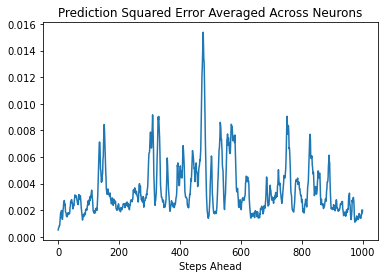

In [138]:
plt.plot(prediction_mse[0][0])
plt.xlabel('Steps Ahead')
plt.title('Prediction Squared Error Averaged Across Neurons')
plt.show()

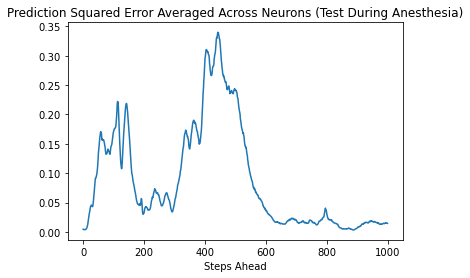

In [134]:
plt.plot(prediction_mse[0][0])
plt.xlabel('Steps Ahead')
plt.title('Prediction Squared Error Averaged Across Neurons (Test During Anesthesia)')
plt.show()

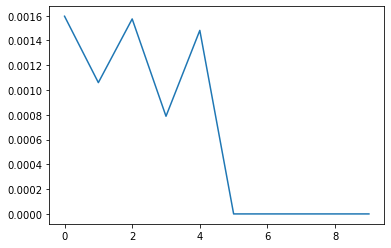

In [107]:
plt.plot(prediction_mse[:10, :].mean(axis=2))